# xgboost with different data preprocessing and training parameter
* This method have the score on LeaderBoard = 0.88338

# Load the data

In [2]:
import pandas as pd
import numpy as np
import gc
import itertools
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
DATA_FOLDER = '../input/'
train     = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train_v2.csv'))
items     = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cats = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops     = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test      = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
test['date_block_num'] = 34
groupby_cols = ['date_block_num', 'shop_id', 'item_id']

# Add some features

I did not extract too much information from text fields, just 2 features:
**city** (which is also encoded in **shop_id**),
and **meta_cat** (some meta category, higher level aggregation of a **category** field)

In [3]:
#category
cat = items[['item_id', 'item_category_id']].drop_duplicates()
cat.set_index(['item_id'], inplace=True)
cat = cat.item_category_id
train['cat'] = train.item_id.map(cat)

#meta_category   games, gifts, work, etc.
item_cats['meta_cat'] = item_cats.item_category_name.apply(lambda x: x.split(' ')[0])
item_cats['meta_cat'] = pd.Categorical(item_cats.meta_cat).codes
item_cats.set_index(['item_category_id'], inplace=True)
meta_cat = item_cats.meta_cat
train['meta_cat'] = train.cat.map(meta_cat)

#city
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(shops['city']).codes
city = shops.city
train['city'] = train.shop_id.map(city)

#year
year = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[2]))], axis=1).drop_duplicates()
year.set_index(['date_block_num'], inplace=True)
year = year.date.append( pd.Series([2015], index=[34]) )

#month
month = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[1]))], axis=1).drop_duplicates()
month.set_index(['date_block_num'], inplace=True)
month = month.date.append( pd.Series([11], index=[34]) )

In [4]:
all_shops_items = []

for block_num in train['date_block_num'].unique():
    unique_shops = train[ train['date_block_num']==block_num ]['shop_id'].unique()
    unique_items = train[ train['date_block_num']==block_num ]['item_id'].unique()
    all_shops_items.append( np.array( list( itertools.product([block_num], unique_shops, unique_items) ), dtype='int32' ) )

df = pd.DataFrame( np.vstack( all_shops_items ), columns=groupby_cols , dtype='int32')
df = df.append(test )

df['ID'] = df.ID.fillna(-1).astype('int32')

df['year'] = df.date_block_num.map(year)
df['month'] = df.date_block_num.map(month)
df['cat'] = df.item_id.map(cat)
df['meta_cat'] = df.cat.map(meta_cat)
df['city'] = df.shop_id.map(city)
train['cat'] = train.item_id.map(cat)

e:\pycharmproject\dsai\venv\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
df.sample(5)

,ID,date_block_num,item_id,shop_id,year,month,cat,meta_cat,city
1700944,-1,4,2108,50,2013,5,55,9,24
8272334,-1,23,16542,30,2014,12,55,9,13
2966124,-1,7,8285,2,2013,8,40,7,0
5404202,-1,14,10407,41,2014,3,40,7,18
8246201,-1,23,4701,27,2014,12,57,9,13


# Some plots.
Overall trend - the sales are decreasing. Peaks on December. date_block_num's [0: 12] contain quite a lot of training data, it is useful to keep them in the training set.

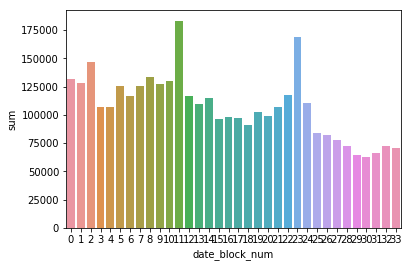

In [6]:
gb = train.groupby(by=['date_block_num'], as_index=False).agg({ 'item_cnt_day': ['sum']})
sns.barplot(x=gb['date_block_num'], y=gb['item_cnt_day']['sum'])

Most of the target values are just Zeros.

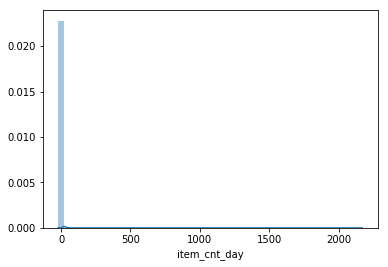

In [7]:
sns.distplot(train['item_cnt_day'])

Zeros and ones are just dominating.

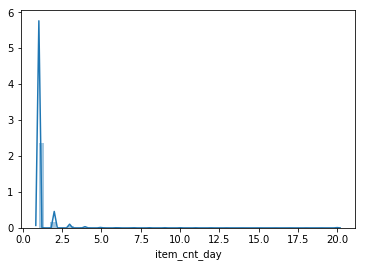

In [8]:
sns.distplot( train[ train['item_cnt_day'] > 0 ]['item_cnt_day'].clip(0, 20) )

# Calculating different aggregations

In [9]:
gb = train.groupby(by=groupby_cols, as_index=False).agg({ 'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target'}, inplace=True)
df = pd.merge(df, gb, how='left', on=groupby_cols)

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_item'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

gb = train.groupby(by=['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_shop'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'shop_id'])

gb = train.groupby( by=['date_block_num', 'cat'], as_index=False).agg({ 'item_cnt_day': ['sum'] })
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_cat'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'cat'])

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price':['mean', 'max']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_price_mean':'target_price_mean', 'item_price_max':'target_price_max'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

# Clipping some outlier prices

In [10]:
df['target_price_mean'] = np.minimum(df['target_price_mean'], df['target_price_mean'].quantile(0.99))
df['target_price_max'] = np.minimum(df['target_price_max'], df['target_price_max'].quantile(0.99))

df.fillna(0, inplace=True)
df['target'] = df['target'].clip(0, 20)
df['target_zero'] = (df['target'] > 0).astype("int32")

e:\pycharmproject\dsai\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in minimum
  """Entry point for launching an IPython kernel.
e:\pycharmproject\dsai\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in minimum
  


# Mean Encodings

In [11]:
%%time
for enc_cols in [['shop_id', 'cat'], ['shop_id', 'item_id'], ['shop_id'], ['item_id']]:
    
    col = '_'.join(['enc', *enc_cols])
    col2 = '_'.join(['enc_max', *enc_cols])
    df[col] = np.nan
    df[col2] = np.nan
    
    print(col, col2)
    
    for d in tqdm_notebook(df.date_block_num.unique()):
        

        f1 = df.date_block_num < d
        f2 = df.date_block_num == d

        gb = df.loc[f1].groupby(enc_cols)[['target']].mean().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col] = enc['target']
        
        gb = df.loc[f1].groupby(enc_cols)[['target']].max().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col2] = enc['target']
        

enc_shop_id_cat enc_max_shop_id_cat



enc_shop_id_item_id enc_max_shop_id_item_id



enc_shop_id enc_max_shop_id



enc_item_id enc_max_item_id



Wall time: 4min 46s


In [12]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float32_cols = [c for c in df if df[c].dtype == "float64"]
    int32_cols = [c for c in df if df[c].dtype in ["int64", "int16", "int8"] ]
            
    # Downcast
    df[float32_cols] = df[float32_cols].astype(np.float32)
    df[int32_cols]   = df[int32_cols].astype(np.int32)
        
    return df

In [13]:
df.fillna(0, inplace=True)
df = downcast_dtypes(df)

# Historical values

In [18]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import gc
from time import sleep

groupby_cols = ['date_block_num', 'shop_id', 'item_id']
shift_range = [1, 2, 3, 4, 5, 12]
shifted_columns = [c for c in df if 'target' in c]
print(shifted_columns)

['target', 'target_item', 'target_shop', 'target_cat', 'target_price_mean', 'target_price_max', 'target_zero']


In [23]:
#%%time
for shift in tqdm_notebook(shift_range):
    print(shift)
    shifted_data = df[groupby_cols + shifted_columns].copy()
    shifted_data['date_block_num'] = shifted_data['date_block_num'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in shifted_columns else x
    shifted_data = shifted_data.rename(columns=foo)
    
    
    df = pd.merge(df, shifted_data, how='left', on=groupby_cols).fillna(0)
    df = downcast_dtypes(df)

    del shifted_data
    gc.collect()
    sleep(1)

1
2
3
4
5
12



# Features Interaction
A big breakthrough happened, when i encoded these interactions. Check it out.

In [24]:
df['target_trend_1_2'] = df['target_lag_1'] - df['target_lag_2']
df['target_predict_1_2'] = df['target_lag_1']*2 - df['target_lag_2']

df['target_trend_3_4'] = df['target_lag_1'] + df['target_lag_2'] - df['target_lag_3'] - df['target_lag_4']
df['target_predict_3_4'] = (df['target_lag_1'] + df['target_lag_2'])*2 - df['target_lag_3'] - df['target_lag_4']

df['target_item_trend_1_2'] = df['target_item_lag_1'] - df['target_item_lag_2']
df['target_item_trend_3_4'] = df['target_item_lag_1'] + df['target_item_lag_2'] - df['target_item_lag_3'] - df['target_item_lag_4']
df['target_shop_trend_1_2'] = df['target_shop_lag_1'] - df['target_shop_lag_2']
df['target_shop_trend_3_4'] = df['target_shop_lag_1'] + df['target_shop_lag_2'] - df['target_shop_lag_3'] - df['target_shop_lag_4']

In [25]:
df = downcast_dtypes(df)
df.to_pickle("df.pkl")

# XGBoost part

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score, roc_curve, roc_auc_score
import gc
import xgboost as xgb
from sklearn.model_selection import train_test_split
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
df = pd.read_pickle("df.pkl")

drop_columns = [c for c in df if c[-1] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] and c.startswith('target')]
drop_columns += ['ID']
features = df.columns.difference( drop_columns )

f0 = df.date_block_num < 34
f1 = df.date_block_num == 34

train, val = train_test_split(df[f0], test_size=0.2, stratify=df[f0]['target'])
test = df[f1]


In [3]:
Train = xgb.DMatrix( train[features], train['target'] )
Val = xgb.DMatrix( val[features], val['target'] )
Test = xgb.DMatrix( test[features])

e:\pycharmproject\dsai\venv\lib\site-packages\xgboost-0.83.dev0-py3.6.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
e:\pycharmproject\dsai\venv\lib\site-packages\xgboost-0.83.dev0-py3.6.egg\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [4]:
del df
gc.collect()

25

For the hyperparameters optimization see the Hyperopt section below. Here are the parameters, which turned out to be optimal.

In [5]:
#%%time

xgb_params = {'booster': 'gbtree',
          'eta': .1,
          'min_child_weight': 100,
          'max_depth': 6,  ##6
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'silent': False,
          'nthread': 8,
          'tree_method': 'gpu_hist'}

model = xgb.train(xgb_params, Train, 1000, [(Train, 'Train'), (Val, 'Val')], early_stopping_rounds=10, verbose_eval=1 )

test['item_cnt_month'] = model.predict(Test).clip(0, 20)
test[['ID', 'item_cnt_month']].sort_values('ID').to_csv('boost_pred.csv', index=False)

[11:36:13] WARNING: C:/dev/libs/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Train-rmse:1.18922	Val-rmse:1.1892
Multiple eval metrics have been passed: 'Val-rmse' will be used for early stopping.

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Train-rmse:1.14695	Val-rmse:1.14702
[2]	Train-rmse:1.1112	Val-rmse:1.11137
[3]	Train-rmse:1.08075	Val-rmse:1.08093
[4]	Train-rmse:1.05519	Val-rmse:1.05533
[5]	Train-rmse:1.03315	Val-rmse:1.03331
[6]	Train-rmse:1.01488	Val-rmse:1.0151
[7]	Train-rmse:0.999349	Val-rmse:0.999569
[8]	Train-rmse:0.985756	Val-rmse:0.985992
[9]	Train-rmse:0.974669	Val-rmse:0.974927
[10]	Train-rmse:0.964936	Val-rmse:0.965195
[11]	Train-rmse:0.956958	Val-rmse:0.957264
[12]	Train-rmse:0.950104	Val-rmse:0.950427
[13]	Train-rmse:0.943943	Val-rmse:0.944308
[14]	Train-rmse:0.939047	Val-rmse:0.939491
[15]	Train-rmse:0.934458	Val-rmse:0.934876
[16]	Train-rmse:0.930571	Val-rmse:0.931101
[17]	Train-rmse:0.9

[184]	Train-rmse:0.859146	Val-rmse:0.865135
[185]	Train-rmse:0.858965	Val-rmse:0.864984
[186]	Train-rmse:0.858801	Val-rmse:0.864821
[187]	Train-rmse:0.85814	Val-rmse:0.864218
[188]	Train-rmse:0.85791	Val-rmse:0.863955
[189]	Train-rmse:0.857714	Val-rmse:0.863753
[190]	Train-rmse:0.857014	Val-rmse:0.863035
[191]	Train-rmse:0.856893	Val-rmse:0.862921
[192]	Train-rmse:0.856763	Val-rmse:0.862794
[193]	Train-rmse:0.856644	Val-rmse:0.862699
[194]	Train-rmse:0.856507	Val-rmse:0.862561
[195]	Train-rmse:0.856438	Val-rmse:0.862531
[196]	Train-rmse:0.856285	Val-rmse:0.862391
[197]	Train-rmse:0.855995	Val-rmse:0.862146
[198]	Train-rmse:0.855922	Val-rmse:0.862087
[199]	Train-rmse:0.855802	Val-rmse:0.862025
[200]	Train-rmse:0.855741	Val-rmse:0.861985
[201]	Train-rmse:0.855585	Val-rmse:0.861856
[202]	Train-rmse:0.855369	Val-rmse:0.861668
[203]	Train-rmse:0.855283	Val-rmse:0.861612
[204]	Train-rmse:0.85521	Val-rmse:0.861577
[205]	Train-rmse:0.855166	Val-rmse:0.861557
[206]	Train-rmse:0.855121	Val-rmse:

[372]	Train-rmse:0.835987	Val-rmse:0.846349
[373]	Train-rmse:0.835908	Val-rmse:0.846286
[374]	Train-rmse:0.835808	Val-rmse:0.846203
[375]	Train-rmse:0.835717	Val-rmse:0.846121
[376]	Train-rmse:0.835629	Val-rmse:0.846044
[377]	Train-rmse:0.835529	Val-rmse:0.845978
[378]	Train-rmse:0.835431	Val-rmse:0.8459
[379]	Train-rmse:0.835396	Val-rmse:0.845879
[380]	Train-rmse:0.835328	Val-rmse:0.845827
[381]	Train-rmse:0.835307	Val-rmse:0.845821
[382]	Train-rmse:0.834948	Val-rmse:0.845454
[383]	Train-rmse:0.834851	Val-rmse:0.845393
[384]	Train-rmse:0.834803	Val-rmse:0.84536
[385]	Train-rmse:0.834569	Val-rmse:0.84517
[386]	Train-rmse:0.83427	Val-rmse:0.844859
[387]	Train-rmse:0.834174	Val-rmse:0.844772
[388]	Train-rmse:0.834106	Val-rmse:0.844725
[389]	Train-rmse:0.834087	Val-rmse:0.844717
[390]	Train-rmse:0.834012	Val-rmse:0.844681
[391]	Train-rmse:0.833979	Val-rmse:0.844676
[392]	Train-rmse:0.833906	Val-rmse:0.844624
[393]	Train-rmse:0.833828	Val-rmse:0.844576
[394]	Train-rmse:0.833754	Val-rmse:0.

[560]	Train-rmse:0.819974	Val-rmse:0.833888
[561]	Train-rmse:0.819961	Val-rmse:0.833885
[562]	Train-rmse:0.819835	Val-rmse:0.833786
[563]	Train-rmse:0.819807	Val-rmse:0.833774
[564]	Train-rmse:0.819752	Val-rmse:0.833772
[565]	Train-rmse:0.819635	Val-rmse:0.833682
[566]	Train-rmse:0.81957	Val-rmse:0.833635
[567]	Train-rmse:0.819293	Val-rmse:0.833378
[568]	Train-rmse:0.819048	Val-rmse:0.833179
[569]	Train-rmse:0.819018	Val-rmse:0.833166
[570]	Train-rmse:0.818984	Val-rmse:0.833172
[571]	Train-rmse:0.818957	Val-rmse:0.833162
[572]	Train-rmse:0.818887	Val-rmse:0.833123
[573]	Train-rmse:0.818841	Val-rmse:0.833096
[574]	Train-rmse:0.818816	Val-rmse:0.833093
[575]	Train-rmse:0.818783	Val-rmse:0.833074
[576]	Train-rmse:0.818709	Val-rmse:0.833023
[577]	Train-rmse:0.818659	Val-rmse:0.832997
[578]	Train-rmse:0.818634	Val-rmse:0.832984
[579]	Train-rmse:0.818547	Val-rmse:0.832904
[580]	Train-rmse:0.818473	Val-rmse:0.832859
[581]	Train-rmse:0.81844	Val-rmse:0.832856
[582]	Train-rmse:0.818222	Val-rmse

[748]	Train-rmse:0.809242	Val-rmse:0.826402
[749]	Train-rmse:0.80922	Val-rmse:0.826393
[750]	Train-rmse:0.809197	Val-rmse:0.826383
[751]	Train-rmse:0.809136	Val-rmse:0.826339
[752]	Train-rmse:0.809112	Val-rmse:0.826328
[753]	Train-rmse:0.808951	Val-rmse:0.826166
[754]	Train-rmse:0.808938	Val-rmse:0.826166
[755]	Train-rmse:0.808886	Val-rmse:0.826146
[756]	Train-rmse:0.808829	Val-rmse:0.826087
[757]	Train-rmse:0.80881	Val-rmse:0.826088
[758]	Train-rmse:0.808768	Val-rmse:0.826062
[759]	Train-rmse:0.808755	Val-rmse:0.826055
[760]	Train-rmse:0.808723	Val-rmse:0.826036
[761]	Train-rmse:0.808674	Val-rmse:0.825992
[762]	Train-rmse:0.808632	Val-rmse:0.825958
[763]	Train-rmse:0.808521	Val-rmse:0.825852
[764]	Train-rmse:0.808508	Val-rmse:0.825843
[765]	Train-rmse:0.808457	Val-rmse:0.825816
[766]	Train-rmse:0.808418	Val-rmse:0.825798
[767]	Train-rmse:0.808354	Val-rmse:0.825744
[768]	Train-rmse:0.808255	Val-rmse:0.825655
[769]	Train-rmse:0.808061	Val-rmse:0.825441
[770]	Train-rmse:0.808038	Val-rmse

[936]	Train-rmse:0.799626	Val-rmse:0.819583
[937]	Train-rmse:0.799611	Val-rmse:0.819576
[938]	Train-rmse:0.799579	Val-rmse:0.819554
[939]	Train-rmse:0.79954	Val-rmse:0.81953
[940]	Train-rmse:0.799477	Val-rmse:0.819491
[941]	Train-rmse:0.799456	Val-rmse:0.819482
[942]	Train-rmse:0.799385	Val-rmse:0.819438
[943]	Train-rmse:0.799365	Val-rmse:0.819437
[944]	Train-rmse:0.799314	Val-rmse:0.819397
[945]	Train-rmse:0.799146	Val-rmse:0.81926
[946]	Train-rmse:0.799103	Val-rmse:0.819228
[947]	Train-rmse:0.79899	Val-rmse:0.819122
[948]	Train-rmse:0.798939	Val-rmse:0.819104
[949]	Train-rmse:0.798892	Val-rmse:0.81908
[950]	Train-rmse:0.798841	Val-rmse:0.819046
[951]	Train-rmse:0.798801	Val-rmse:0.819021
[952]	Train-rmse:0.798757	Val-rmse:0.819002
[953]	Train-rmse:0.798669	Val-rmse:0.818952
[954]	Train-rmse:0.798647	Val-rmse:0.818944
[955]	Train-rmse:0.798604	Val-rmse:0.818913
[956]	Train-rmse:0.798576	Val-rmse:0.818895
[957]	Train-rmse:0.798535	Val-rmse:0.818884
[958]	Train-rmse:0.798509	Val-rmse:0.

In [6]:
#pickle.dump(model, open("xgb.pickle", "wb"))

In [7]:
#model = pickle.load(open("xgb.pickle", "rb"))

**item_id**, **date_block_num** and **month** have quite a predictive power :)

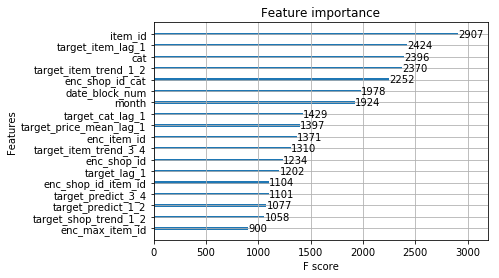

In [10]:
xgb.plot_importance(booster=model, max_num_features=18) ##12